<a href="https://colab.research.google.com/github/Negfir/Bayesian-GA/blob/main/PGM_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import math 
from pomegranate import BayesianNetwork
import time
import numpy as np                
import pandas as pd                 
import plotly.graph_objects as go  
np.random.seed(1234)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import matplotlib.pyplot as plt
tf.debugging.set_log_device_placement(True)

tf.random.set_seed(
    7
)


Num GPUs Available:  1


In [2]:
!pip install -U pymoo

     |████████████████████████████████| 3.7MB 5.4MB/s 
     |████████████████████████████████| 245kB 33.2MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4939870 sha256=25f3625acaefb778f7870d2ea118b23b3a73f50a43022a8cc7f250f87a74f86d
  Stored in directory: /root/.cache/pip/wheels/95/13/7a/b9489d4dc66ef0b7d03f6cc3be7535b9b2f18d83893437ad7c
Successfully built pymoo


In [3]:
!pip install pomegranate
# !pip uninstall numpy
# !pip install numpy


     |████████████████████████████████| 17.9MB 1.5MB/s 
     |████████████████████████████████| 15.3MB 393kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


## Implement a Transformer block as a layer

In [29]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).

In [30]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## Download and prepare dataset

In [31]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



25000 Training sequences
25000 Validation sequences


## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.

In [ ]:

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:

## Train and Evaluate

In [47]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def transformerFit(X):
    embed_dim = X[0]
    num_heads = X[1]
    ff_dim = X[2]
    print("Variables are:",embed_dim ,num_heads,ff_dim)

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)


    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    batch = 32
    import time



    history = model.fit(
        x_train, y_train, batch_size=batch, epochs=2, verbose=0
    )


    start = time.time()
    results = model.evaluate(x_val, y_val, batch_size=batch)
    print("test loss, test acc:", results)
    end = time.time()
    latency = end - start

    return latency, results[1]

In [33]:
fitness = transformerFit(16, 4, 64)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:

In [ ]:
fitness

rowInput = np.append([8,4,64],fitness)
rowInput

array([ 8.        ,  4.        , 64.        ,  8.28272462,  0.87252003])

# **Optimization**

In [18]:
def fitnessFunc(chromosome):
    """F1 Sphere model
    unimodal, symmetric, separable"""
    fitness = 0
    for i in range(len(chromosome)):
        fitness += chromosome[i]**2
    return fitness #, fitness+3

def ZDT1(x):
    f1 = x[0]  # objective 1
    g = 1 + 9 * np.sum(x[1:D] / (D-1))
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h  # objective 2
    
    return [f1, f2]

D = 3
x = np.random.rand(D)

for f1 in np.linspace(0, 1, num=20):
    f2 = 1 - np.sqrt(f1)
    true_front = np.vstack([true_front, [f1, f2]])  

true_front = pd.DataFrame(true_front, columns=['f1', 'f2'])  # convert to DataFrame

objective_values = np.empty((0, 2))

for i in range(50):
    x = np.random.rand(D)
    y = ZDT1(x)
    objective_values = np.vstack([objective_values, y])

# convert to DataFrame
objective_values = pd.DataFrame(objective_values, columns=['f1', 'f2'])
objective_values.head()


fig = go.Figure(layout=dict(xaxis=dict(title='f1'), yaxis=dict(title='f2')))

fig.add_scatter(x=objective_values.f1, y=objective_values.f2,
                name='Solutions', mode='markers')

fig.add_scatter(x=true_front.f1, y=true_front.f2, name='True Front')

fig.show()
objective_values.head()

NameError: ignored

In [5]:
from numpy import random
class EncoderDecoder:
  def __init__(self, decimal_rep, binary_rep):
    self.decimal_rep = np.array(decimal_rep)
    self.binary_rep = np.array(binary_rep)

  def encode(self,row):
    np.array(row)
    for i,r in enumerate(self.decimal_rep):
      if np.array_equal(r,row):
        return self.binary_rep[i]
    return self.binary_rep[random.randint(len(self.binary_rep))]
  
  def decode(self,row):
    np.array(row)
    for i,r in enumerate(self.binary_rep):
      
      if np.array_equal(r,row):
        return self.decimal_rep[i]
    return self.decimal_rep[random.randint(len(self.decimal_rep))]

  def getDecimal(self):
    return self.decimal_rep

  def getBinary(self):
    return self.binary_rep

  def setDecimal(self,inp):
    self.decimal_rep = inp

  def setBinary(self,inp):
   self.binary_rep = inp




In [6]:
embed_dim = [8, 16, 32, 64, 128, 256, 512, 768]
num_heads = [2, 3, 4, 5, 6, 8, 10, 12]
ff_dim = [4, 8, 16, 32, 64, 128, 256, 512]

def bitEncoder(var):
  lenght = len(var)
  encoded = []
  for i,v in enumerate(var):
      encoded.append(np.binary_repr(i, width=math.ceil(np.log2(lenght))))
  return encoded

def bitDecoder(var):
  lenght = len(var)
  decoded = []
  for i,v in enumerate(var):
      decoded.append(np.base_repr(i, 10))
  print( decoded)

bitEncoder(embed_dim)

['000', '001', '010', '011', '100', '101', '110', '111']

In [7]:



def sample(chromosome, sample_size):
    idx = np.random.randint(low=0, high=chromosome.shape[0], size=sample_size)
    initial_population = []
    
    for i in idx:
        # print("Selected samples are:",chromosome[i])
        fit = fitnessFunction(chromosome[i])
        initial_population.append(list(np.append(chromosome[i],fit)))
    initial_population = np.asarray(initial_population)
    # print(initial_population)
    return initial_population


def getFitness(chromosome):
    initial_population = [] 
    for i in range(len(chromosome)):
        fit = fitnessFunction(chromosome[i])
        initial_population.append(list(np.append(chromosome[i],fit)))
    initial_population = np.asarray(initial_population)
    return initial_population

In [8]:
def non_dominated_sorting_algorithm(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)
    del front[len(front)-1]
    return front

In [9]:
def NDS(X, slice):
  X = X.values
  width = X.shape[1]-1
  idx = non_dominated_sorting_algorithm(X[width-1],X[width])
  new_pop = np.empty([slice,X.shape[1]])
  cnt = 0
  for front in idx:
    for i in front:
      if cnt < slice:
        #  print(new_pop.shape,X.shape)
        new_pop[cnt] = X[i]
  return new_pop

In [ ]:
values1 = [1,2,7,8,5,0,9]
values2 = [20,24,12,25,30,14,15]
non_dominated_sorting_algorithm(values1, values2)

[[3, 4, 6], [1, 2], [0], [5]]

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 31 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [10]:
def sortSelect(population, percentage, isMO = False):
    X_raw = pd.DataFrame(population)
    X_raw = X_raw.drop_duplicates()
    width = population.shape[1]-1
    if (not isMO):
      X_raw = X_raw.sort_values(by=[population.shape[1]-1])

      X_raw = X_raw.drop(columns=[width]).values
      slice_ = percentage#math.floor(population.shape[0]*percentage)
      top_pop = X_raw[:slice_]

    else:
      slice_ = percentage#math.floor(population.shape[0]*percentage)
      X_raw = pd.DataFrame(NDS(X_raw,slice_))
      # print("shape is",X_raw.values.shape)
      X_raw = X_raw.drop(columns=[width])
      X_raw = X_raw.drop(columns=[width-1]).values
      top_pop = X_raw

    return top_pop 

def binaryEncoder(chrom):
    pop = []   
    for n in chrom:
        arr = []
        bin = data.encode(n)
        for item in bin:
          digits =  [x for x in str(item)]
          arr = np.append(arr,digits)
        pop.append(list(arr))
    return pop


def seperator(stringIn,NUM_VARIABLES,VAR_SIZE):
  tmp = []
  for i in range(NUM_VARIABLES):
    tmp.append( [''.join(stringIn[VAR_SIZE*i:VAR_SIZE*i+VAR_SIZE])])
  return([j for sub in tmp for j in sub])



In [ ]:

from pomegranate import BayesianNetwork



# print("Greedy")
# print("Time (s): ", t)
# print("P(D|M): ", p)
# model.plot()

embed_dim = [8, 16, 32, 64, 128, 256, 512, 768]
num_heads = [2, 3, 4, 5, 6, 8, 10, 12]
ff_dim = [4, 8, 16, 32, 64, 128, 256, 512]

NUM_VARIABLES = 2
VAR_SIZE = 3

variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, 3)




# var1 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var2 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var3 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

NUM_VARIABLES = 3

begin = -5
end = 5
inc = (end-begin)/15
inc1 = 5/15
inc2=3/15


var1 = np.arange(start=begin, stop=end + inc, step=inc)
var2 = np.arange(start=begin, stop=end + inc, step=inc)
var3 = np.arange(start=begin, stop=end + inc, step=inc)

var1 = np.arange(start=0, stop=5 + inc, step=inc1)
var2 = np.arange(start=0, stop=3 + inc, step=inc2)

var1_bin = bitEncoder(var1)
var2_bin = bitEncoder(var2)
var3_bin = bitEncoder(var3)


embed_dim = np.array([8, 16, 32, 64, 128, 256, 512, 768])
num_heads = np.array([2, 3, 4, 5, 6, 8, 10, 12])
ff_dim = np.array([4, 8, 16, 32, 64, 128, 256, 512])

var1_bin = bitEncoder(embed_dim)
var2_bin = bitEncoder(num_heads)
var3_bin = bitEncoder(ff_dim)

# variables = np.array(
#   np.meshgrid(var1, var2)).T.reshape(-1, NUM_VARIABLES)
# variables_bin = np.array(
#   np.meshgrid(var1_bin, var2_bin)).T.reshape(-1, NUM_VARIABLES)


variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, NUM_VARIABLES)
variables_bin = np.array(
  np.meshgrid(var1_bin, var2_bin, var3_bin)).T.reshape(-1, NUM_VARIABLES)

data = EncoderDecoder(variables,variables_bin)

####################################################
new_pop = variables
print(variables)


POP_SIZE = 40
population = sample(new_pop, POP_SIZE)

chrom = sortSelect(population,int(POP_SIZE*0.5),True)
POP_SIZE = int(POP_SIZE*0.5)

for generation in range(5):
    print("Generation:",generation, "...")
    X = binaryEncoder(chrom)

    model = BayesianNetwork.from_samples(X, algorithm='chow-liu') 
  
    p = model.log_probability(X).sum()

    BO_size = int(POP_SIZE*0.7)
    sampled = model.sample(BO_size)
    child = []
    for c in sampled: 
      child.append(list(data.decode(seperator(c,NUM_VARIABLES,VAR_SIZE))))

    print(len(child))
    old_size = POP_SIZE - BO_size
    idx = np.random.randint(low=0, high=variables.shape[0], size=old_size-int(old_size*0.75))

    
    new_pop =  np.concatenate((np.array(child),chrom[0:int(old_size*0.75)],variables[list(idx)]), axis=0)
    chrom = sortSelect(getFitness(new_pop),int(POP_SIZE*0.5),True) 
    print(len(new_pop))

f1 = []
f2 = []


for c in chrom:
  f1.append(fitnessFunction(c)[1])
  f2.append(fitnessFunction(c)[0])
  # print(list(problem.evaluate(c)),c)
plt.scatter(f2, f1, marker='o')
f1_ = np.array(f1)
f2_ = np.array(f2)
idx = non_dominated_sorting_algorithm(f1, f2)
f1_ = f1_[list(idx[0])]
f2_ = f2_[list(idx[0])]

# plt.scatter(f2_, f1_, marker='o')

Streaming output truncated to the last 5000 lines.
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_9831 in d

In [12]:
f1 =[]
f2 = []

for c in chrom:

  f1.append(fitnessFunction(c)[1])
  f2.append(fitnessFunction(c)[0])
  # print(list(problem.evaluate(c)),c)
# plt.scatter(f2, f1, marker='o')
f1_ = np.array(f1)
f2_ = np.array(f2)
idx = non_dominated_sorting_algorithm(f1, f2)
f1_ = f1_[list(idx[0])]
f2_ = f2_[list(idx[0])]

plt.scatter(f2_, f1_, marker='o')

NameError: ignored

In [185]:
print(f1_,f2_)

[-12.58605822 -20.         -12.58605822 -20.        ] [-5.25135470e+000  1.41311679e-247 -5.25135470e+000  1.41311679e-247]


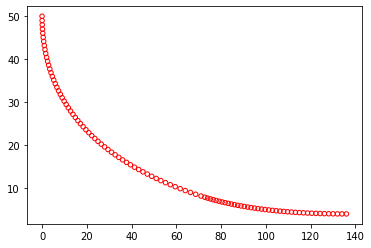

In [27]:
from pymoo.factory import get_problem
from pymoo.util.plotting import plot

problem = get_problem("bnh")
plot(problem.pareto_front(), no_fill=True)

list(problem.evaluate([3,5])[0])

def fitnessFunction (X):
  # return list(problem.evaluate(X)[0])
  return transformerFit(X)

# fitnessFunction ([3,2])

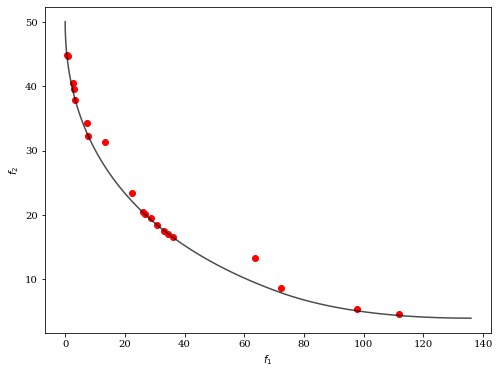

In [246]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("bnh")

algorithm = NSGA2(pop_size=20)

res = minimize(problem,
               algorithm,
               ('n_gen', 2),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()
